In [18]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Create New Dataset - data_v3

## What?

Problems with `data_v2`:

**Too much padding**: 

After more thoroughly exploring the width and height distributions of each resolution groups I found that the chosen dimensions were waaay too big. This is potentially causing the model to be confused - ie it's getting too much information about neighbouring farms to make any decisions about the current farm. 

So, we will go from:

```python
MAX_DIMS = {
    "10": (90, 90), 
    "20": (50, 50), 
    "60": (20, 20)
}
```


to...

```python
MAX_DIMS = {
    "10": (30, 30), 
#     "20": (15, 15), (not included in v3)
#     "60": (5, 5)    (not included in v3)
}
```

_Note that `data_v3` will not include resolution groups 20 and 60. Rather, we will focus on one resolution group for now. More details on this below_


**Non-selective bands**: 

In `data_v2` I just stacked _all the bands_ for each resolution group. This might be a good idea in the longer term, but before we can iron out the kinks of our network, it will be smart to start with the most basic number of channels possible. 

Thus, for this dataset I will use only 3 bands in the 10m resolution group:

* Band 2: Blue
* Band 3: Green
* NDVI: (Band 8 - Band 4) / (Band 8 + Band 4)

Yup, that means I'll be calculating a new band - the NDVI band.


**Numpy format**

To utilize the built-in functionality of Keras (and other) data loaders, we need to have the data in a known image compression format such as JPEG of PNG. Now, with only 3 bands we can save the data in JPG format and take full advantage of data loading. 



## How?

**Input data**: `data_v2/{train/test}/2017-02-10/res_10/`

Yup, we will use only one time stamp of data...

**Output format**: `data_v3/{train/test}/{class_id}/{farm_id}.jpg`

In [79]:
import os
import cv2

import rasterio
import numpy as np

from pathlib import Path
import matplotlib.pyplot as plt

from config import processed_data_dir

from src.utils import read_shapefile

RES_GROUP = '10'
DATE = '2017-02-10'
OUT_PATH = Path(os.path.join(processed_data_dir,'data_v3'))
INPUT_PATH = Path(os.path.join(processed_data_dir,'data_v2'))

BANDS_ORDER = ['B02','B03','B04','B08','MASK_1','MASK_2']

In [27]:
train_shp = read_shapefile('train')
test_shp = read_shapefile('test')

### Show one image from data_v2

In [62]:
id = 1000
fp = INPUT_PATH / "train" / DATE / RES_GROUP / f"{id}.npy"
arr = np.load(fp)
arr.shape

(6, 90, 90)

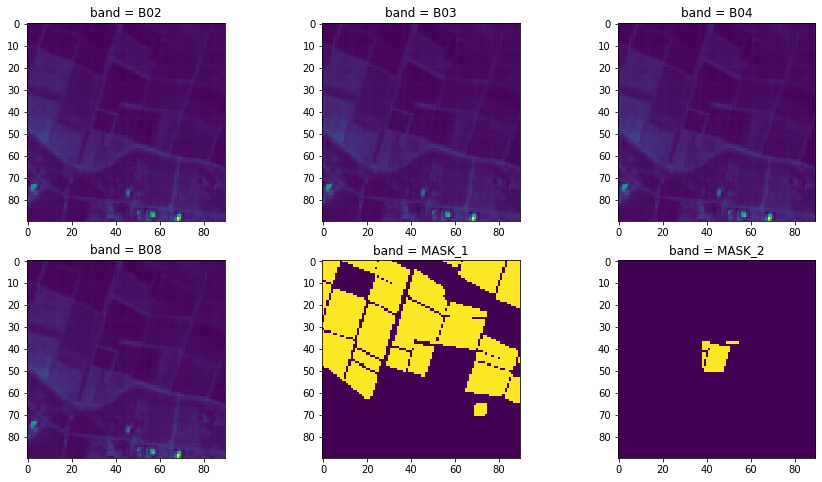

In [63]:
def plot_band(arr, i, ax):
    ax.imshow(arr[i])
    ax.set_title(f'band = {BANDS_ORDER[i]}')

fig, axes = plt.subplots(2,3, figsize=(15,8))

i = 0
ax=axes[0][0]
plot_band(arr, i, ax)

i = 1
ax=axes[0][1]
plot_band(arr, i, ax)

i = 2
ax=axes[0][2]
plot_band(arr, i, ax)

i = 3
ax=axes[1][0]
plot_band(arr, i, ax)

i = 4
ax=axes[1][1]
plot_band(arr, i, ax)

i = 5
ax=axes[1][2]
plot_band(arr, i, ax)

plt.show()

## Re-crop

Original image is 90x90, desired is 30x30 so we can just select the middle 30 pixels ^_^

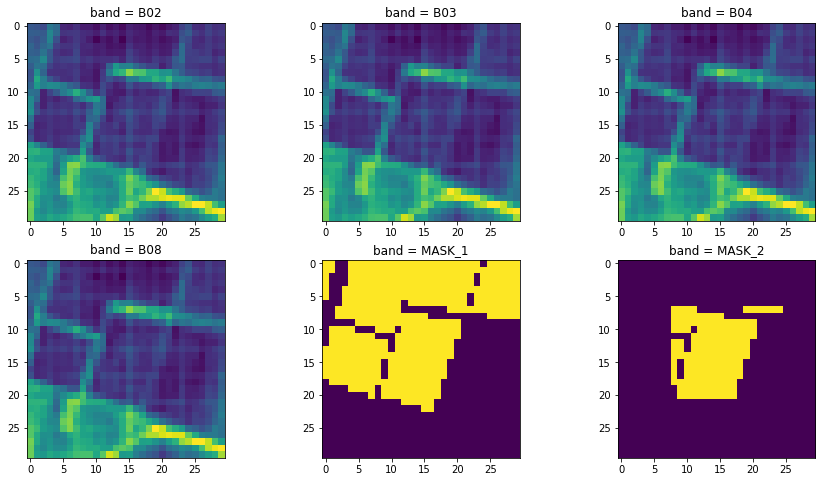

In [64]:
def re_crop(arr):
    return arr[:, 30:-30, 30:-30]

cropped_arr = re_crop(arr)

fig, axes = plt.subplots(2,3, figsize=(15,8))

i = 0
ax=axes[0][0]
plot_band(cropped_arr, i, ax)

i = 1
ax=axes[0][1]
plot_band(cropped_arr, i, ax)

i = 2
ax=axes[0][2]
plot_band(cropped_arr, i, ax)

i = 3
ax=axes[1][0]
plot_band(cropped_arr, i, ax)

i = 4
ax=axes[1][1]
plot_band(cropped_arr, i, ax)

i = 5
ax=axes[1][2]
plot_band(cropped_arr, i, ax)

plt.show()

**Looks good!**

## Calculate NDVI

In [65]:
def calc_ndvi(arr):
    return (arr[4] - arr[3]) / (arr[4] + arr[3])

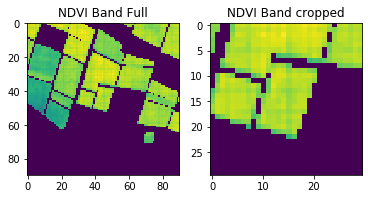

In [66]:
# Do for full and cropped
ndvi_band_full = calc_ndvi(arr)
ndvi_band_cropped = calc_ndvi(cropped_arr)

fig, axes = plt.subplots(1, 2)

ax = axes[0]
ax.imshow(ndvi_band_full)
ax.set_title('NDVI Band Full')


ax = axes[1]
ax.imshow(ndvi_band_cropped)
ax.set_title('NDVI Band cropped')

plt.show()

**Seems to work very well at highlighting crops**

## Combine cropping, NDVI and selecting bands

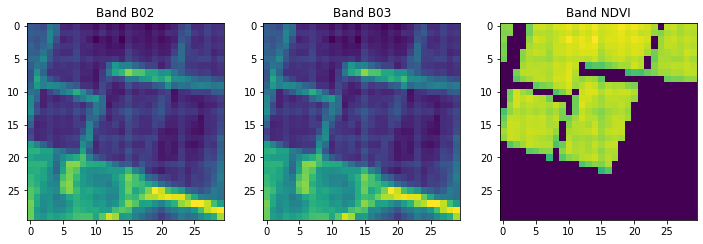

In [67]:
def v3_from_v2(arr):
    
    # First crop
    arr = re_crop(arr)
    
    # Calculate ndvi
    ndvi = calc_ndvi(arr)
    
    new_arr = np.zeros((30, 30, 3))
    
    # Images generally have the band at the final index
    new_arr[:, :, 0] = arr[0]
    new_arr[:, :, 1] = arr[1]
    new_arr[:, :, 2] = ndvi
    
    return new_arr

arr_v3 = v3_from_v2(arr)

fig, axes = plt.subplots(1, 3, figsize=(12,8))

ax = axes[0]
ax.imshow(arr_v3[:,:,0])
ax.set_title('Band B02')

ax = axes[1]
ax.imshow(arr_v3[:, :, 1])
ax.set_title('Band B03')

ax = axes[2]
ax.imshow(arr_v3[:, :, 2])
ax.set_title('Band NDVI')

plt.show()

Still some surrounding farms in the cropped image...

In [68]:
def load_v2_set(dataset, ids, date=DATE, res=RES_GROUP):
    """
    Load data from data_v2 for a list of ids
    """
    path = INPUT_PATH / dataset / date / res
    
    return {id: np.load(path/ f'{id}.npy') for id in ids}


def create_v3_set(v2_set):
    
    v3_set = {id: v3_from_v2(arr) for id, arr in v2_set.items()}
    
    return v3_set

## Run v2-->v3 for some random choices

---------------------------------------- 2747 ----------------------------------------


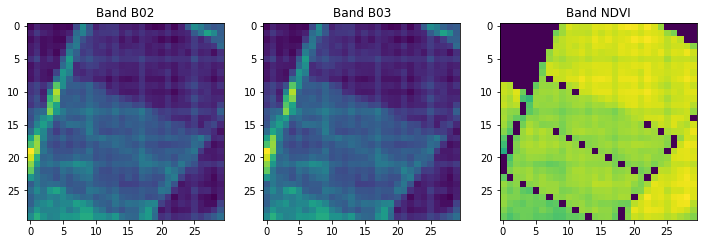

---------------------------------------- 2970 ----------------------------------------


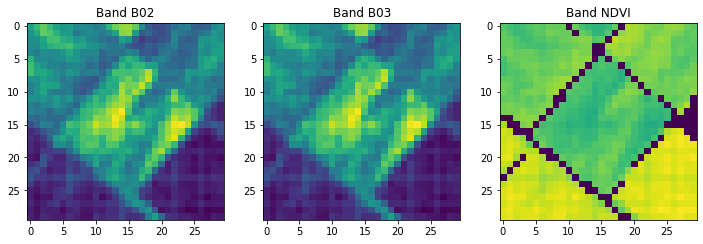

---------------------------------------- 3149 ----------------------------------------


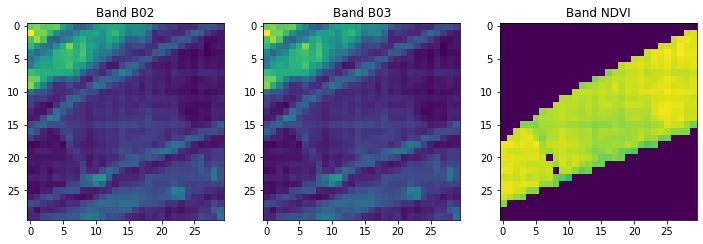

---------------------------------------- 863 ----------------------------------------


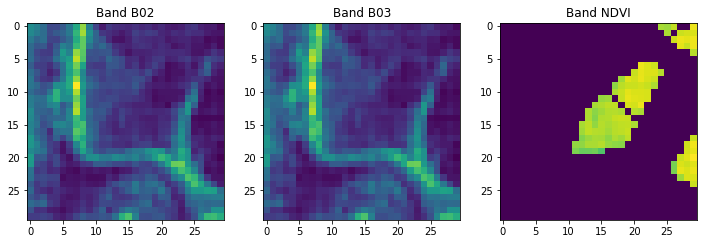

In [76]:
ids = np.random.choice(train_shp.index.to_list(), 4)

v2_set = load_v2_set("train", ids)

v3_set = create_v3(v2_set)

for id, v3_arr in v3_set.items():
    print('-'*40,id,'-'*40)
    fig, axes = plt.subplots(1, 3, figsize=(12,8))

    ax = axes[0]
    ax.imshow(v3_arr[:,:,0])
    ax.set_title('Band B02')

    ax = axes[1]
    ax.imshow(v3_arr[:, :, 1])
    ax.set_title('Band B03')

    ax = axes[2]
    ax.imshow(v3_arr[:, :, 2])
    ax.set_title('Band NDVI')

    plt.show()

## Run for train set

In [98]:
dataset = 'train'
shp_df = read_shapefile(dataset)
classes = np.arange(1, 10)
for farm_class in list(map(str, classes)):
    
    print('-'*30,'Class: ',farm_class, '-'*30)

    ids = shp_df.loc[shp_df.Crop_Id_Ne == farm_class].index.to_list()

    print('Loading v2 set...',end='')
    v2_set = load_v2_set("train", ids)
    print('done')

    print('Transforming v2 -> v3 ...',end='')
    v3_set = create_v3(v2_set)
    print('done!')


    for farm_id, arr in v3_set.items():

        class_dir = OUT_PATH / dataset / farm_class

        out_fp = class_dir / f'{farm_id}.jpg'

        if not class_dir.exists():
            class_dir.mkdir()

        if not out_fp.exists():
            cv2.imwrite(str(out_fp), arr)
        else:
            continue

------------------------------ Class:  1 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  2 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  3 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  4 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  5 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  6 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  7 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!
------------------------------ Class:  8 ------------------------------
Loading v2 set...done
Transforming v2 -> v3 ...done!


## Run for test set

In [101]:
dataset = 'test'
shp_df = read_shapefile(dataset)

ids = shp_df.index.to_list()

print('Loading v2 set...',end='')
v2_set = load_v2_set(dataset, ids)
print('done')

print('Transforming v2 -> v3 ...',end='')
v3_set = create_v3(v2_set)
print('done!')

for farm_id, arr in v3_set.items():

    class_dir = OUT_PATH / dataset

    out_fp = class_dir / f'{farm_id}.jpg'

    if not class_dir.exists():
        class_dir.mkdir()

    if not out_fp.exists():
        cv2.imwrite(str(out_fp), arr)
    else:
        continue

Loading v2 set...done
Transforming v2 -> v3 ...done!
